In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the data
df = pd.read_excel("datos_ie.xlsx", header=0)

# Shape of the data
print("Shape of the dataset:")
print(df.shape)

df.head()

Shape of the dataset:
(85436, 117)


,npi,countyID,census_tract,zip5,service_year,service_quarter,standard_services_claims,tele_services_claims,total_claims,standard_services_patients,...,total_other_payers_claims,total_other_payers_patients,total_commercial_claims_year,total_commercial_patients_year,total_medicaid_claims_year,total_medicaid_patients_year,total_medicare_claims_year,total_medicare_patients_year,total_other_payers_claims_year,total_other_payers_patients_year
0,1,51,16.04,28348,2020,2,0,0,0,0,...,8,2,0,0,0,0,0,0,16,4
1,1,51,16.04,28348,2020,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,51,16.04,28348,2020,3,0,2,2,0,...,1,1,0,0,0,0,0,0,16,4
3,1,51,16.04,28348,2020,4,0,6,6,0,...,2,1,0,0,0,0,0,0,16,4
4,1,51,16.04,28348,2019,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
# Count null values per column
df.isnull().sum()

npi                                 0
countyID                            0
census_tract                        0
zip5                                0
service_year                        0
                                   ..
total_medicaid_patients_year        0
total_medicare_claims_year          0
total_medicare_patients_year        0
total_other_payers_claims_year      0
total_other_payers_patients_year    0
Length: 117, dtype: int64

- NPI_Deactivation_Reason_Code
- NPI_Deactivation_Date
- NPI_Reactivation_Date
- Specialization_1

Those features contain null values. Actually, the first three are completely null values so we can eliminate them.

In [133]:
# Drop empty columns
df.drop(columns=["NPI_Deactivation_Reason_Code", "NPI_Deactivation_Date", "NPI_Reactivation_Date"],inplace=True)

In [134]:
# Checking the type of the feature is correct
print(df.dtypes)

npi                                   int64
countyID                              int64
census_tract                        float64
zip5                                  int64
service_year                          int64
                                     ...   
total_medicaid_patients_year          int64
total_medicare_claims_year            int64
total_medicare_patients_year          int64
total_other_payers_claims_year        int64
total_other_payers_patients_year      int64
Length: 114, dtype: object


In [135]:
data = df.copy()

In [136]:
# Mapping of quarter to end month in MM/DD format
quarter_end_month = {1: '03/31', 2: '06/30', 3: '09/30', 4: '12/31'}

# Create the 'date' column
data['date'] = data.apply(lambda row: f"{row['service_year']}/{quarter_end_month[row['service_quarter']]}",axis=1)

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='mixed')

#### INSIGHT 1: Tele Claims had a high 'boom' after the COVID-19 pandemic

The analysis of the database began with an examination of the trends for each type of claim over the years covered by the sample (2018-2020). It was observed that the total number of claims increased by 65% in the last quarter of 2020 compared to the same period in the previous year. This rise was primarily driven by a substantial increase in the number of tele claims, which experienced a surge of over 600% in the first quarter of 2020 compared to the preceding quarter. Conversely, the number of standard claims decreased by 62% during the second quarter of 2020, reinforcing the premise that the COVID-19 pandemic had a substantial impact on claim demand during that year.

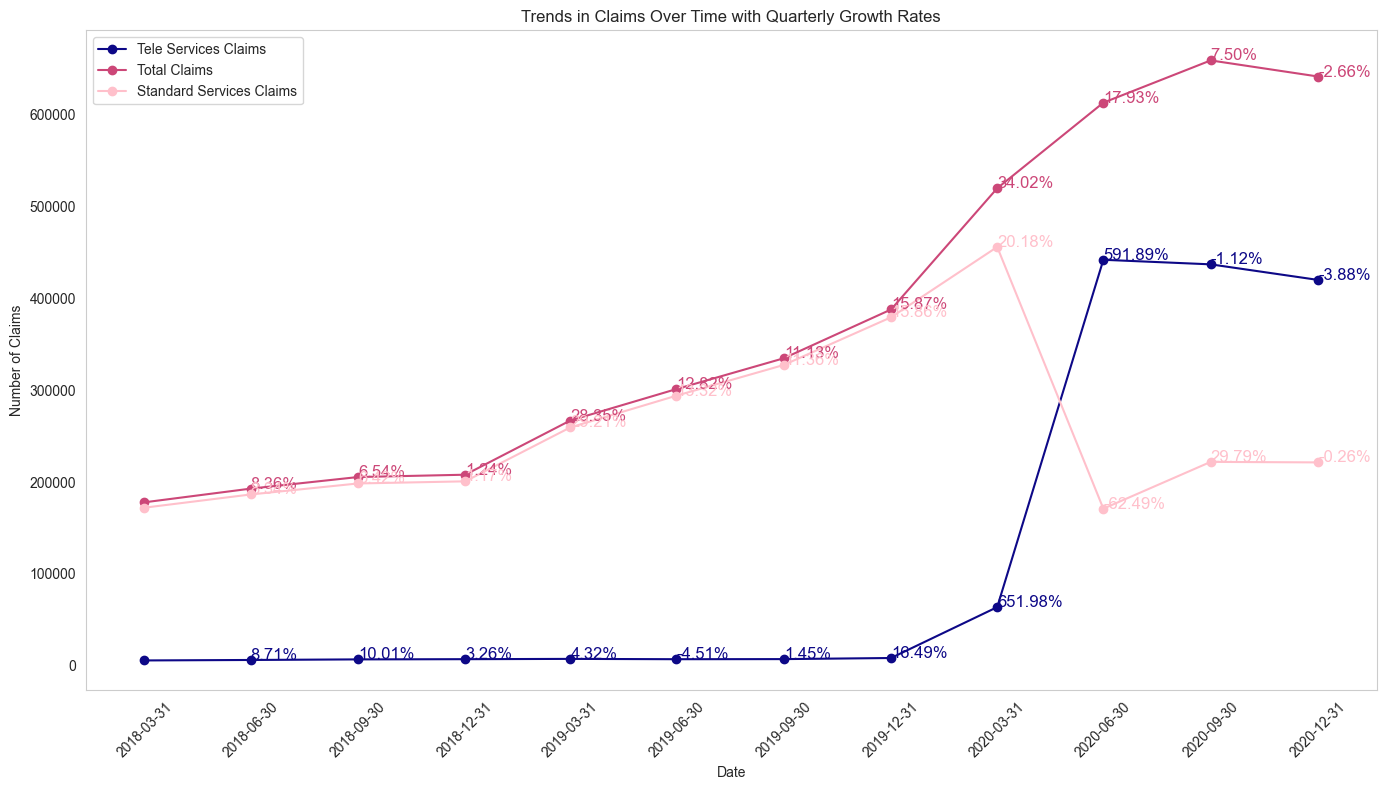

In [137]:
# Grouping claims per date to show trends over time
claims_per_quarter = data.groupby('date')[['tele_services_claims', 'total_claims', 'standard_services_claims']].sum().reset_index()

# Calculate the growth rate
claims_per_quarter['tele_growth_rate'] = claims_per_quarter['tele_services_claims'].pct_change() * 100
claims_per_quarter['total_growth_rate'] = claims_per_quarter['total_claims'].pct_change() * 100
claims_per_quarter['standard_growth_rate'] = claims_per_quarter['standard_services_claims'].pct_change() * 100

# Plotting
plt.figure(figsize=(14, 8))

# Using the Plasma color palette
colors = plt.cm.plasma(np.linspace(0, 1, 3))

# Plotting tele_services_claims
plt.plot(claims_per_quarter['date'], claims_per_quarter['tele_services_claims'], label='Tele Services Claims', marker='o', color=colors[0])
for i in range(len(claims_per_quarter)):
    if not np.isnan(claims_per_quarter['tele_growth_rate'].iloc[i]):
        plt.text(claims_per_quarter['date'].iloc[i], claims_per_quarter['tele_services_claims'].iloc[i],
                 f"{claims_per_quarter['tele_growth_rate'].iloc[i]:.2f}%", color=colors[0], fontsize=12)

# Plotting total_claims
plt.plot(claims_per_quarter['date'], claims_per_quarter['total_claims'], label='Total Claims', marker='o', color=colors[1])
for i in range(len(claims_per_quarter)):
    if not np.isnan(claims_per_quarter['total_growth_rate'].iloc[i]):
        plt.text(claims_per_quarter['date'].iloc[i], claims_per_quarter['total_claims'].iloc[i],
                 f"{claims_per_quarter['total_growth_rate'].iloc[i]:.2f}%", color=colors[1], fontsize=12)

# Plotting standard_services_claims
plt.plot(claims_per_quarter['date'], claims_per_quarter['standard_services_claims'], label='Standard Services Claims', marker='o', color='pink')
for i in range(len(claims_per_quarter)):
    if not np.isnan(claims_per_quarter['standard_growth_rate'].iloc[i]):
        plt.text(claims_per_quarter['date'].iloc[i], claims_per_quarter['standard_services_claims'].iloc[i],
                 f"{claims_per_quarter['standard_growth_rate'].iloc[i]:.2f}%", color='pink', fontsize=12)

# Adding titles and labels
plt.title('Trends in Claims Over Time with Quarterly Growth Rates')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()

# Formatting the x-axis to show quarterly dates
plt.xticks(claims_per_quarter['date'], claims_per_quarter['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

#### INSIGHT 2: Differentiate between standard and tele claims

Secondly, the distribution of standard claims versus tele claims was analyzed, revealing a total of 3,089,836 standard claims compared to 1,420,362 tele claims. This indicates that tele claims constitute 45.9% of the total standard claims in the sample.

Total Sum of Standard Services Claims: 3089836
Total Sum of Tele Services Claims: 1420362


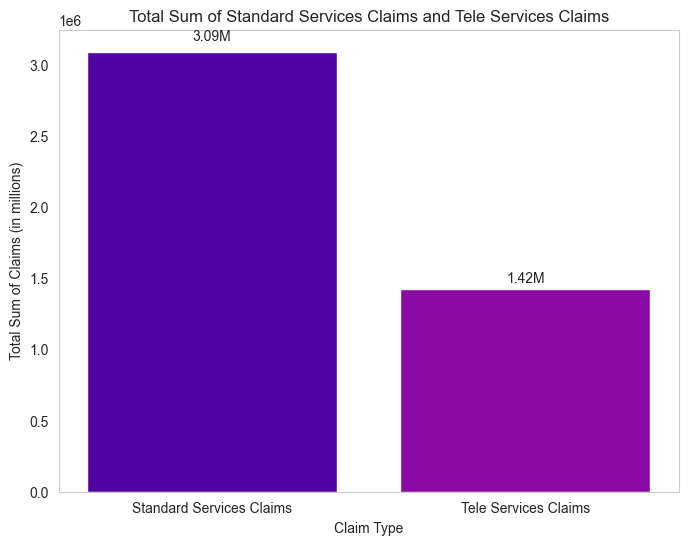

In [138]:
# Total sum of standard and tele claims
total_standard_claims = data['standard_services_claims'].sum()
total_tele_claims = data['tele_services_claims'].sum()

print(f"Total Sum of Standard Services Claims: {total_standard_claims}")
print(f"Total Sum of Tele Services Claims: {total_tele_claims}")

# Data for the bar chart
claims_data = {
    'Standard Services Claims': total_standard_claims,
    'Tele Services Claims': total_tele_claims
}
names = list(claims_data.keys())
values = list(claims_data.values())

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(names, values, color=sns.color_palette("plasma", 6))

# Add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval * 1.02, f'{yval / 1e6:.2f}M', ha='center', va='bottom')  # Adjusted position

# Customize the chart
plt.title('Total Sum of Standard Services Claims and Tele Services Claims')
plt.xlabel('Claim Type')
plt.ylabel('Total Sum of Claims (in millions)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.show()

Additionally, the distribution of tele claims among different healthcare providers was examined. It was observed that 82% of providers have less than 50% of their total claims as tele claims, 15% of providers have more than 50% of their claims as tele claims, and only 2% of providers have an equal distribution of 50% between tele claims and standard claims. This analysis highlights the presence of three distinct types of providers: those who predominantly offer remote services, those who prefer traditional methods, and those who balance between the two.

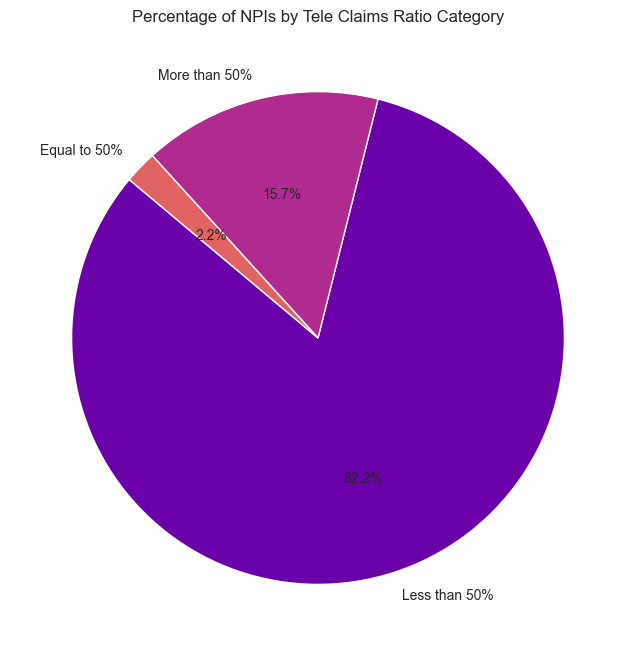

In [139]:
# Tele Claims Ratio calculation
data['tele_claims_ratio'] = data['tele_services_claims'] / (data['total_claims'])

# Group by NPI and calculate mean tele claims ratio
npi_grouped = data.groupby('npi')['tele_claims_ratio'].mean().reset_index()

# Create a column to classify NPIs based on tele claims ratio
def classify_ratio(ratio):
    if ratio < 0.5:
        return 'Less than 50%'
    elif ratio == 0.5:
        return 'Equal to 50%'
    else:
        return 'More than 50%'

npi_grouped['claim_category'] = npi_grouped['tele_claims_ratio'].apply(classify_ratio)

# Count the number of NPIs in each category
count_categories = npi_grouped['claim_category'].value_counts(normalize=True) * 100

# Plotting the pie chart using the plasma palette
plt.figure(figsize=(8, 8))
plt.pie(count_categories, labels=count_categories.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("plasma", 4))
plt.title('Percentage of NPIs by Tele Claims Ratio Category')
plt.show()

#### INSIGHT 3: Check claims by specialization

The top five specializations with the highest number of claims are as follows: Clinical Social Worker with 638,008 claims, Mental Health 547,540, Professional with 475,062 claims, Psychiatry Physician with 345,573 claims and Psychology with 285,669 claims.


In [115]:
# Grouping the data by specialization and summing the claims
# Used the Display_Name feature because it does not have null values
specialization_claims_sum = data.groupby('Display_Name_1')['total_claims'].sum()

# Sorting the sum of claims in descending order and getting the top specializations
top_specializations = specialization_claims_sum.sort_values(ascending=False).head()

# Displaying the top specializations
top_specializations

Display_Name_1
Clinical Social Worker     638008
Mental Health Counselor    547540
Professional Counselor     475062
Psychiatry Physician       345573
Psychologist               285669
Name: total_claims, dtype: int64

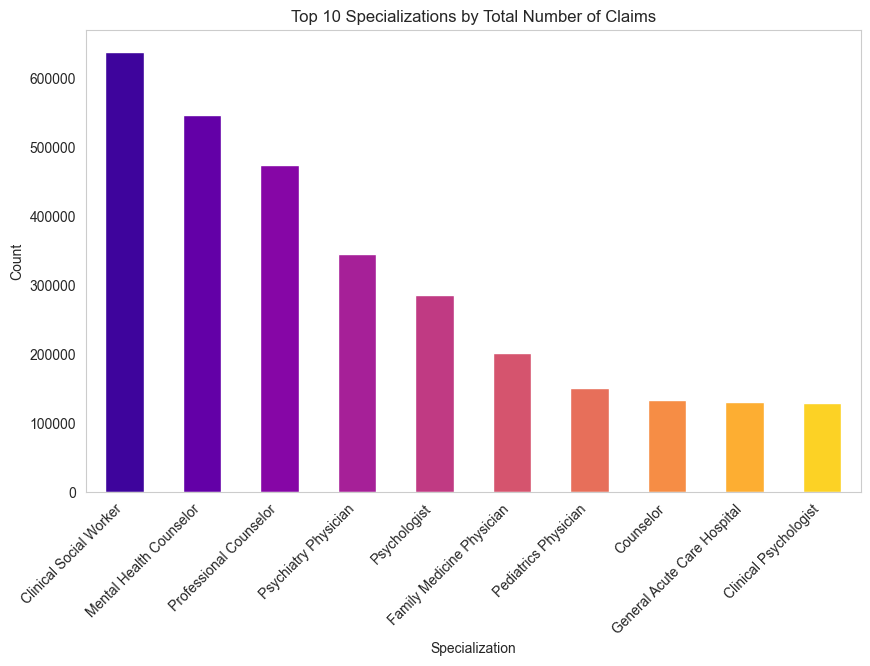

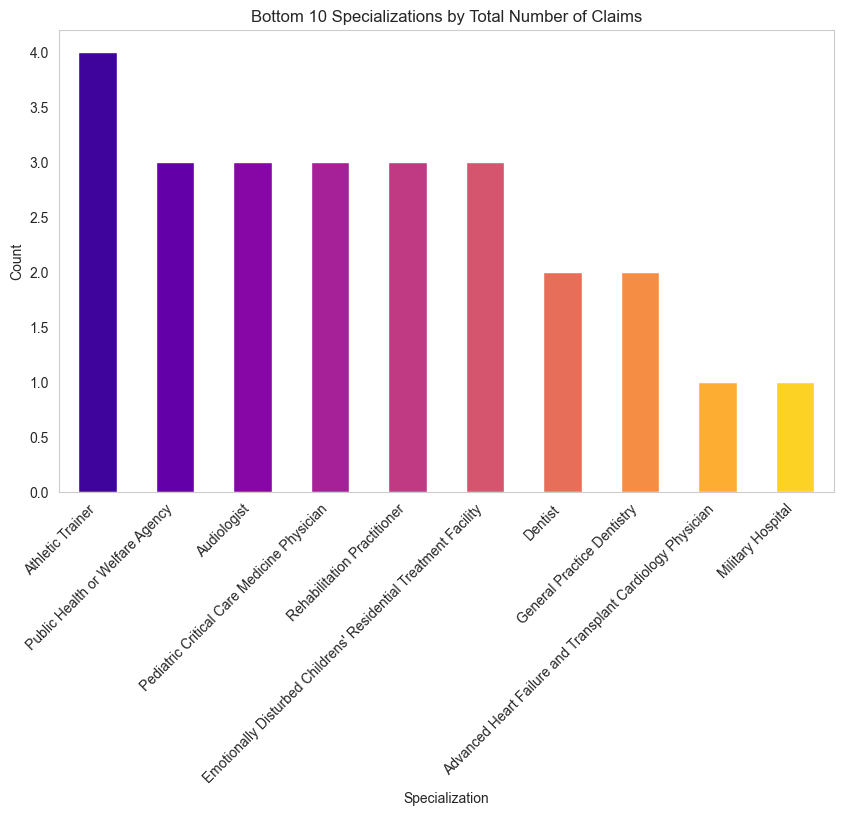

In [140]:
# Filter top 10 and bottom 10 specializations
top_10_specializations = specialization_claims_sum.sort_values(ascending=False).head(10)
bottom_10_specializations = specialization_claims_sum.sort_values(ascending=False).tail(10)

# Plot the top 10 specializations
plt.figure(figsize=(10, 6))
top_10_specializations.plot(kind='bar', color=sns.color_palette("plasma", len(top_10_specializations)))
plt.title('Top 10 Specializations by Total Number of Claims')
plt.xlabel('Specialization')
plt.ylabel('Count')
plt.grid(False)
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the bottom 10 specializations
plt.figure(figsize=(10, 6))
bottom_10_specializations.plot(kind='bar', color=sns.color_palette("plasma", len(bottom_10_specializations)))
plt.title('Bottom 10 Specializations by Total Number of Claims')
plt.xlabel('Specialization')
plt.ylabel('Count')
plt.grid(False)
plt.xticks(rotation=45, ha='right')
plt.show()


#### INSIGHT 5: Claims and Patients throughout the years

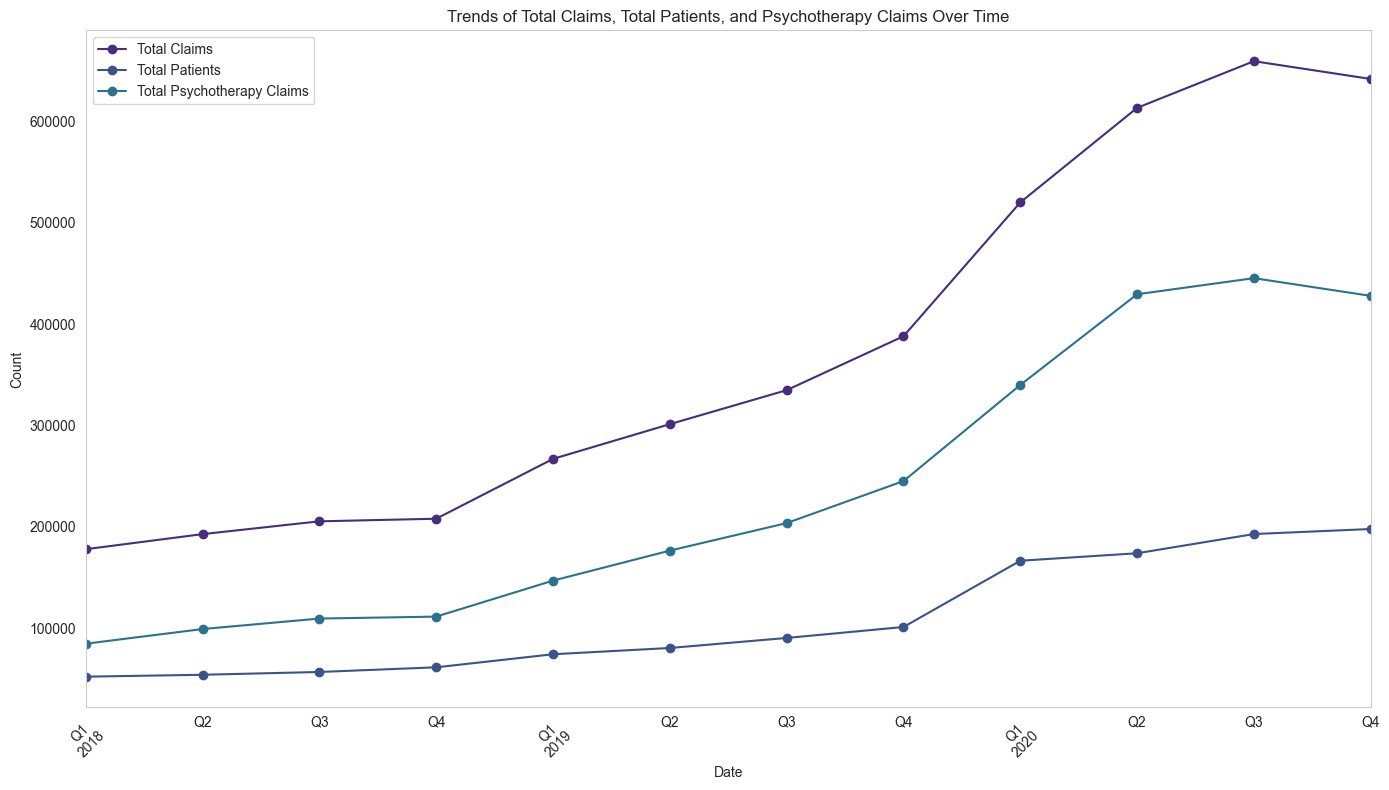

In [141]:
# Grouping by Provider ID and service year
grouped_data = data.groupby(['npi', 'date']).agg({
    'total_claims': 'sum',
    'total_patients': 'sum',
    'total_psychotherapy_claims': 'sum'
}).reset_index()

# Total claims and total patients per provider per year
total_claims_per_year = grouped_data.groupby('date')['total_claims'].sum()
total_patients_per_year = grouped_data.groupby('date')['total_patients'].sum()
total_psycho_claims_per_year = grouped_data.groupby('date')['total_psychotherapy_claims'].sum()

# Setting up the plot
plt.figure(figsize=(14, 8))

# Plotting the trends using the Viridis Plasma palette
colors = sns.color_palette('viridis', 7)

total_claims_per_year.plot(kind='line', marker='o', label='Total Claims', color=colors[0])
total_patients_per_year.plot(kind='line', marker='o', label='Total Patients', color=colors[1])
total_psycho_claims_per_year.plot(kind='line', marker='o', label='Total Psychotherapy Claims', color=colors[2])

# Adding titles and labels
plt.title('Trends of Total Claims, Total Patients, and Psychotherapy Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

#### INSIGHT 6: Top 10 and Bottom 10 counties by number of claims

Moreover, an analysis of claim distribution by county showed that the top five counties with the highest number of both standard and tele claims were identical, including Mecklenburg, Wake, and Buncombe. However, the top five counties with more than 50% tele claims and those with less than 50% tele claims were entirely different, indicating a geographical distinction among providers favoring remote or standard services

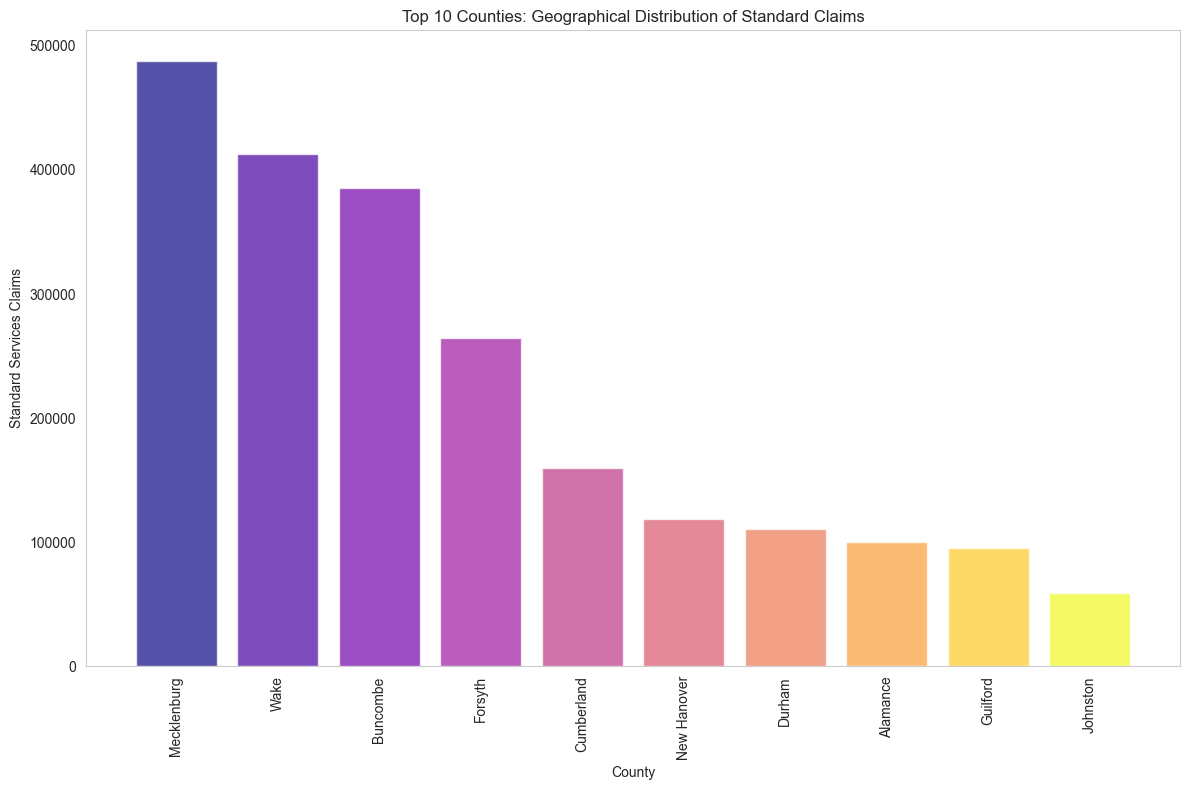

In [142]:
# Grouping by county
county_data = data.groupby('countyname').agg({
    'standard_services_claims': 'sum',
}).reset_index()

# Sorting the data by total claims and selecting the top 10 counties
top_10_counties = county_data.sort_values(by='standard_services_claims', ascending=False).head(10)

# Plotting total claims for the top 10 counties using the Plasma color palette
colors = cm.plasma(np.linspace(0, 1, len(top_10_counties)))

plt.figure(figsize=(12, 8))
plt.bar(top_10_counties['countyname'], top_10_counties['standard_services_claims'], color=colors, alpha=0.7)
plt.title('Top 10 Counties: Geographical Distribution of Standard Claims')
plt.xlabel('County')
plt.ylabel('Standard Services Claims')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.grid(False)
plt.tight_layout()
plt.show()


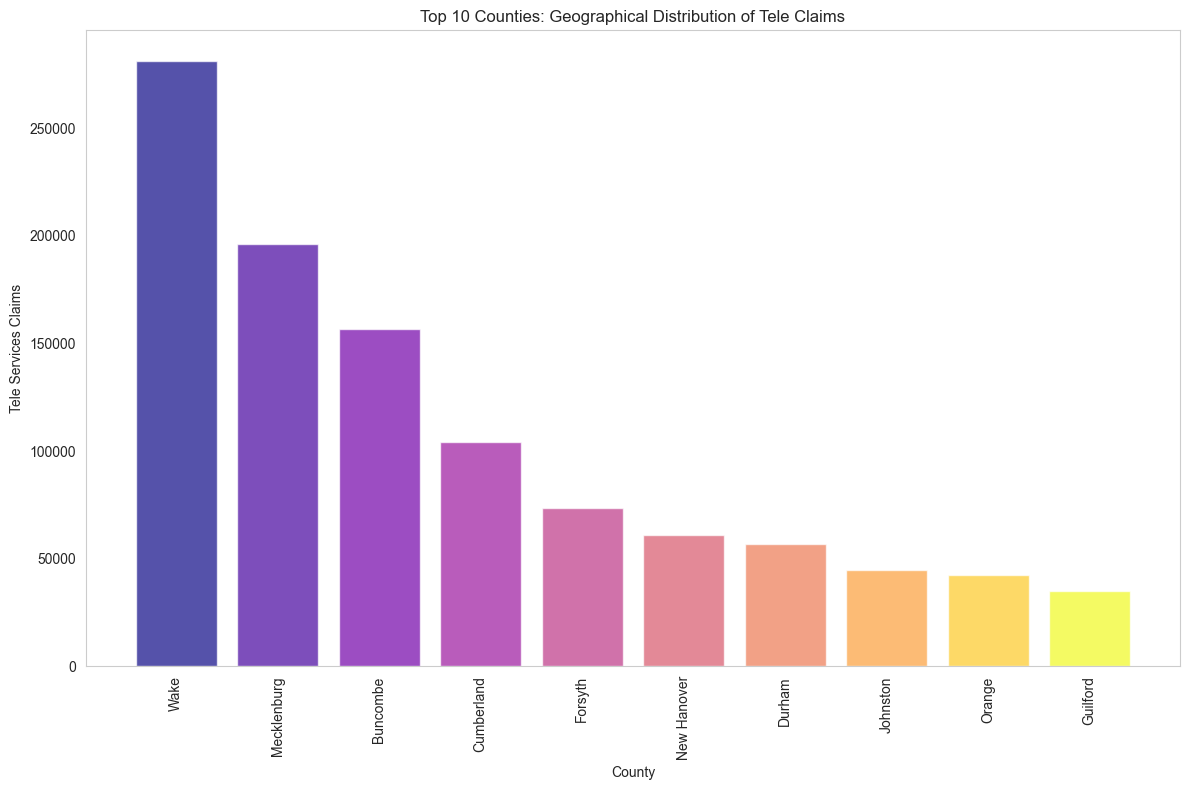

In [143]:
# Grouping by county
county_data = data.groupby('countyname').agg({
    'tele_services_claims': 'sum',
}).reset_index()

# Sorting the data by total claims and selecting the top 10 counties
top_10_counties = county_data.sort_values(by='tele_services_claims', ascending=False).head(10)

# Plotting total claims for the top 10 counties using the Plasma color palette
colors = cm.plasma(np.linspace(0, 1, len(top_10_counties)))

plt.figure(figsize=(12, 8))
plt.bar(top_10_counties['countyname'], top_10_counties['tele_services_claims'], color=colors, alpha=0.7)
plt.title('Top 10 Counties: Geographical Distribution of Tele Claims')
plt.xlabel('County')
plt.ylabel('Tele Services Claims')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.grid(False)
plt.tight_layout()
plt.show()


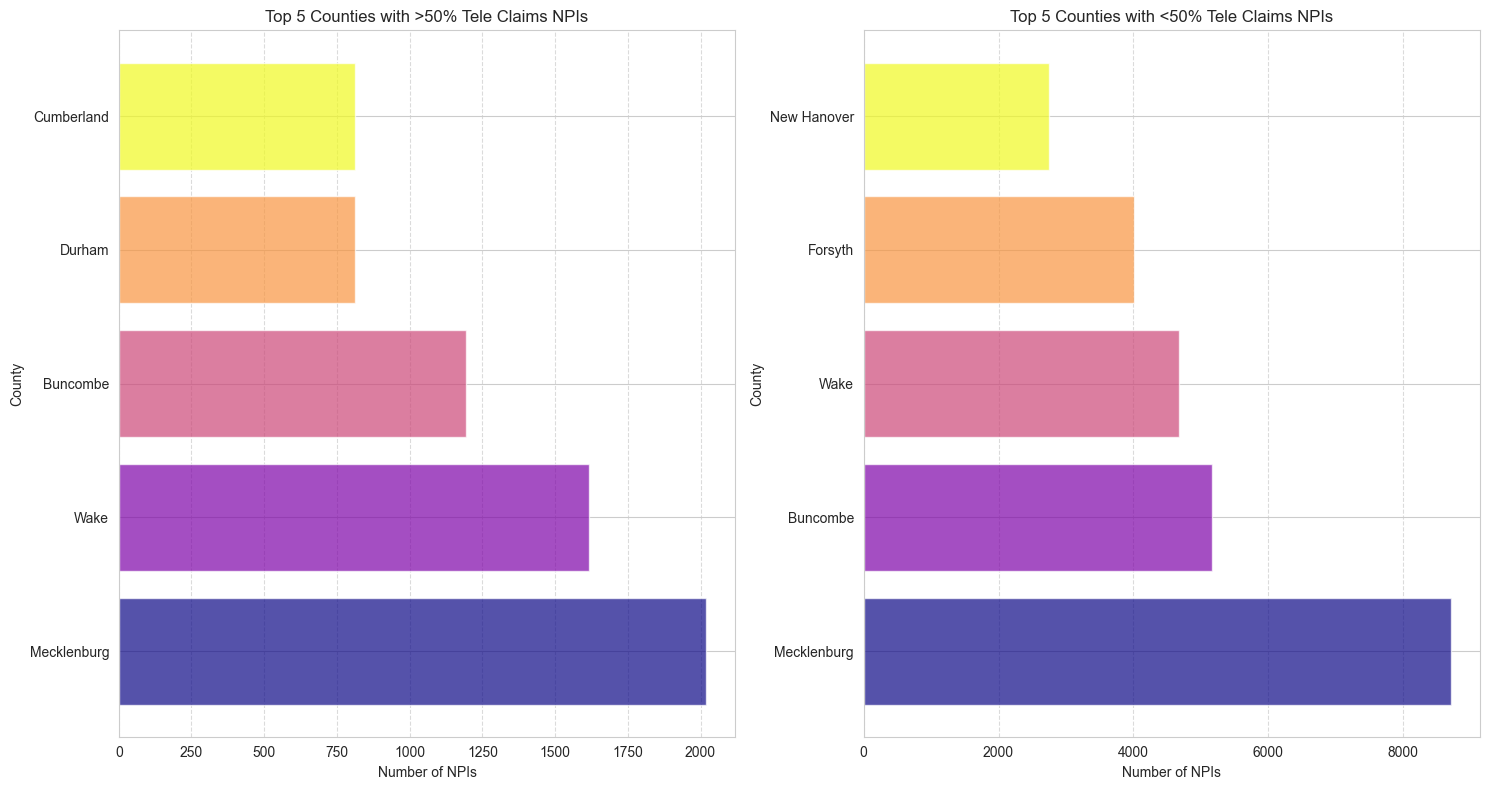

In [144]:
# Calculate the percentage of tele services claims per NPI
data['tele_claims_ratio'] = (data['tele_services_claims'] / data['total_claims']) * 100

# Filter NPIs by their tele claims percentage
more_than_50 = data[data['tele_claims_ratio'] > 50]
less_than_50 = data[data['tele_claims_ratio'] < 50]

# Count NPIs per county
more_than_50_count = more_than_50.groupby('countyname').npi.count().reset_index()
less_than_50_count = less_than_50.groupby('countyname').npi.count().reset_index()

# Sort and select top 5
top_5_more_than_50 = more_than_50_count.sort_values(by='npi', ascending=False).head(5)
top_5_less_than_50 = less_than_50_count.sort_values(by='npi', ascending=False).head(5)

def plot_top_5(df, ax, title):
    colors = cm.plasma(np.linspace(0, 1, len(df)))
    ax.barh(df['countyname'], df['npi'], color=colors, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Number of NPIs')
    ax.set_ylabel('County')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Creating the subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plotting the top 5 counties with the highest number of NPIs where more than 50% of claims are tele claims
plot_top_5(top_5_more_than_50, axs[0], 'Top 5 Counties with >50% Tele Claims NPIs')

# Plotting the top 5 counties with the highest number of NPIs where less than 50% of claims are tele claims
plot_top_5(top_5_less_than_50, axs[1], 'Top 5 Counties with <50% Tele Claims NPIs')

# Adjust layout
plt.tight_layout()
plt.show()

#### INSIGHT 7: Check how the claims differ from the urban and rural areas

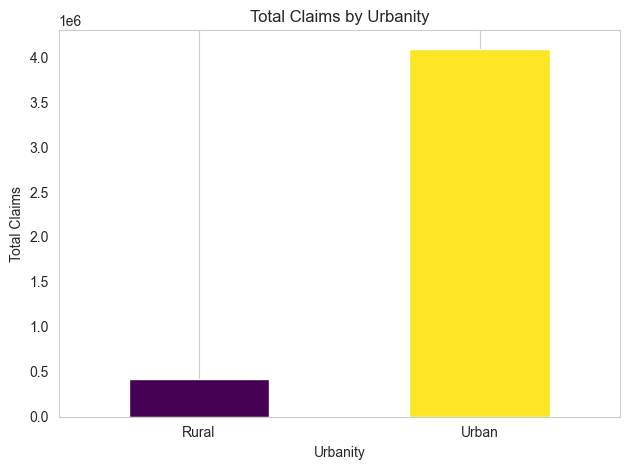

In [145]:
# Grouping by urbanity
claims_by_urbanity = data.groupby('urbanity')['total_claims'].sum()

# Plotting the total claims for urban and rural areas using the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, len(claims_by_urbanity)))

plt.figure()
claims_by_urbanity.plot(kind='bar', color=colors)
plt.title('Total Claims by Urbanity')
plt.xlabel('Urbanity')
plt.ylabel('Total Claims')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### INSIGHT 8: Compare claims of big providers and small “provider size”

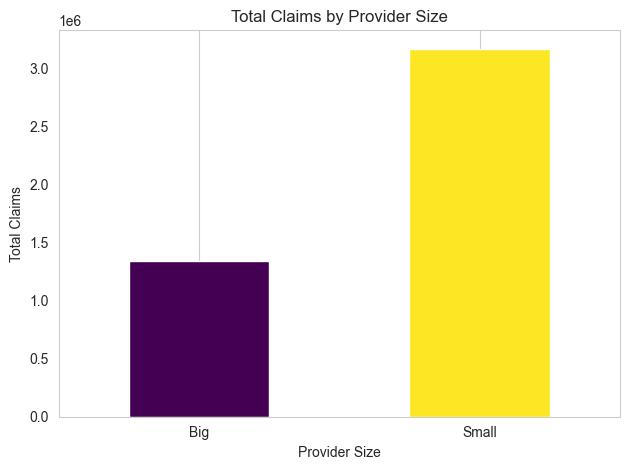

In [146]:
# Grouping by provider size
claims_by_provider_size = data.groupby('provider_size')['total_claims'].sum()

# Plotting the total claims for big and small providers using the Viridis colormap
colors = cm.viridis(np.linspace(0, 1, len(claims_by_provider_size)))

plt.figure()
claims_by_provider_size.plot(kind='bar', color=colors)
plt.title('Total Claims by Provider Size')
plt.xlabel('Provider Size')
plt.ylabel('Total Claims')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### INSIGHT 9: Medicaid Claims and Patients

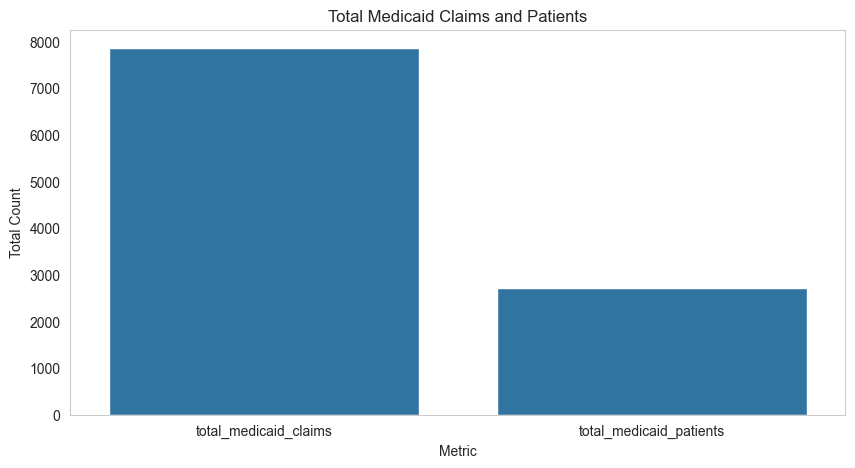

In [147]:
# Aggregate total Medicaid claims and patients
medicaid_stats = data[['total_medicaid_claims', 'total_medicaid_patients']].sum().reset_index()
medicaid_stats.columns = ['Metric', 'Total']

# Plotting Medicaid's role
plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Total', data=medicaid_stats)
plt.title('Total Medicaid Claims and Patients')
plt.xlabel('Metric')
plt.ylabel('Total Count')
plt.grid(False)
plt.show()


#### INSIGHT 10: Understanding the relation between the total claims and their lags

The correlation between the number of claims (total, standard, tele, and psychotherapy) and their historical values were examined. A correlogram analysis (Appendix-Figure 6) revealed that all these variables exhibit strong correlations, particularly with the first lag. In all cases, the first lag exceeds an autocorrelation of 50%, providing a solid foundation for assuming that the behavior of these variables can be predicted based on their historical values.

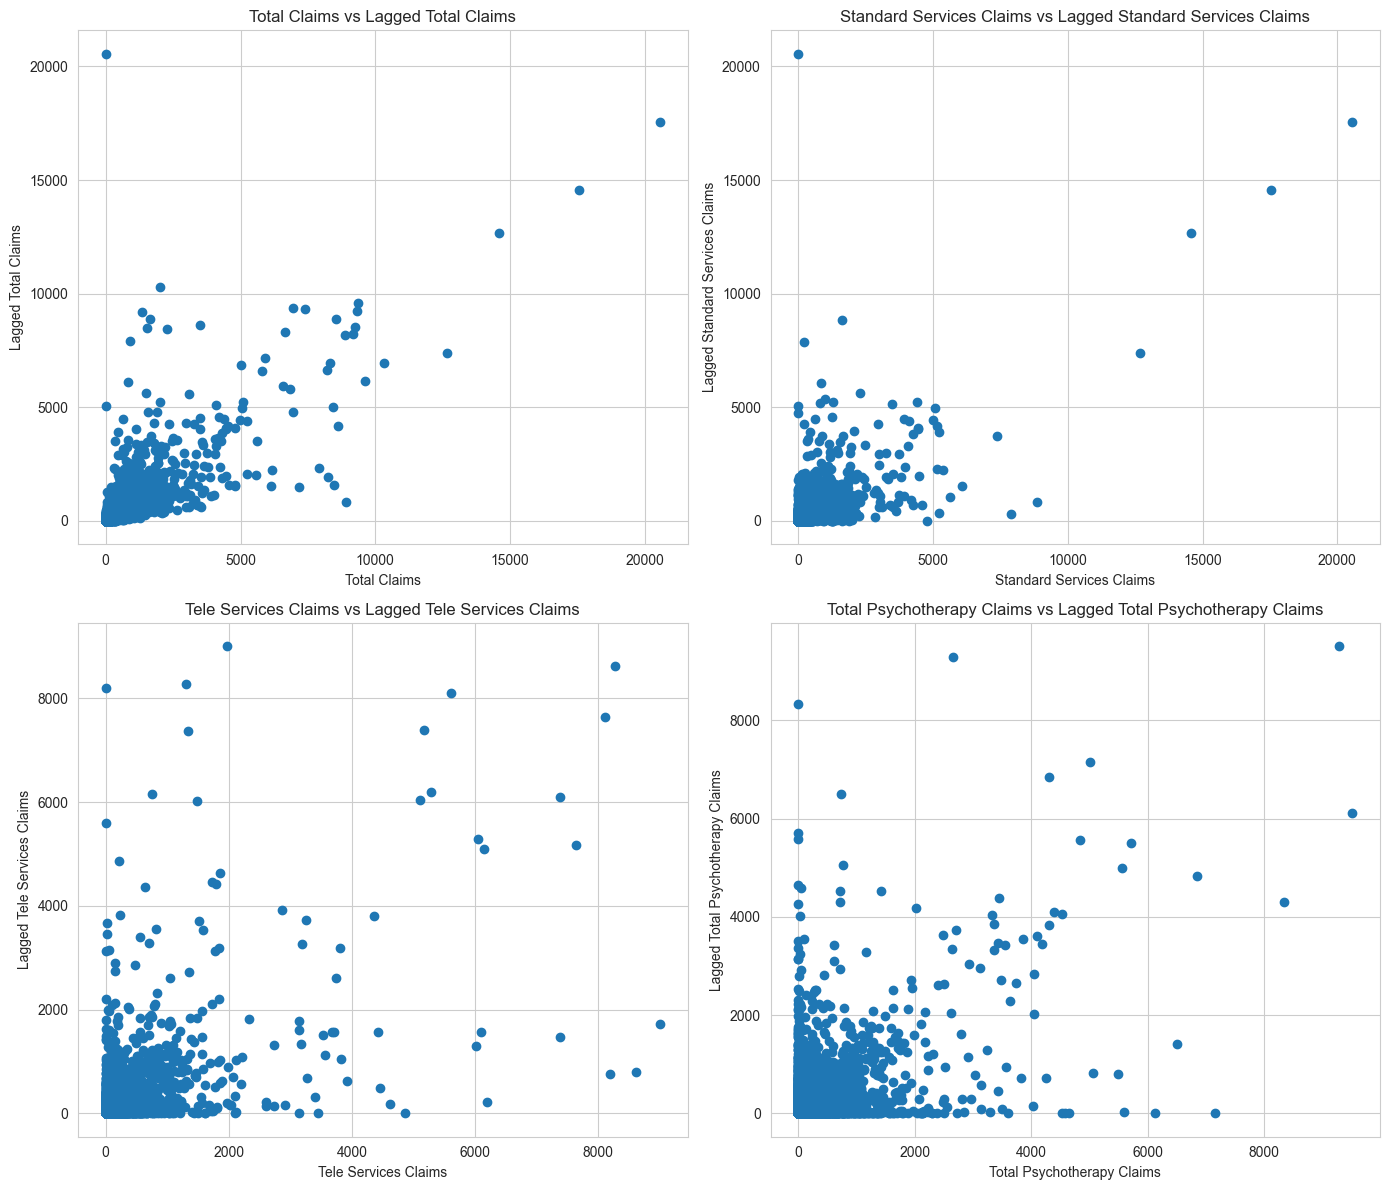

In [148]:
data.set_index('date', inplace=True)

# Create lagged versions of the series
data['total_claims_lag1'] = data['total_claims'].shift(1)
data['standard_services_claims_lag1'] = data['standard_services_claims'].shift(1)
data['tele_services_claims_lag1'] = data['tele_services_claims'].shift(1)
data['total_psychotherapy_claims_lag1'] = data['total_psychotherapy_claims'].shift(1)

# Plotting total claims vs lagged total claims
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.scatter(data['total_claims'], data['total_claims_lag1'])
plt.xlabel('Total Claims')
plt.ylabel('Lagged Total Claims')
plt.title('Total Claims vs Lagged Total Claims')

# Plotting standard services claims vs lagged standard services claims
plt.subplot(2, 2, 2)
plt.scatter(data['standard_services_claims'], data['standard_services_claims_lag1'])
plt.xlabel('Standard Services Claims')
plt.ylabel('Lagged Standard Services Claims')
plt.title('Standard Services Claims vs Lagged Standard Services Claims')

# Plotting tele services claims vs lagged tele services claims
plt.subplot(2, 2, 3)
plt.scatter(data['tele_services_claims'], data['tele_services_claims_lag1'])
plt.xlabel('Tele Services Claims')
plt.ylabel('Lagged Tele Services Claims')
plt.title('Tele Services Claims vs Lagged Tele Services Claims')

# Plotting total psychotherapy claims vs lagged total psychotherapy claims
plt.subplot(2, 2, 4)
plt.scatter(data['total_psychotherapy_claims'], data['total_psychotherapy_claims_lag1'])
plt.xlabel('Total Psychotherapy Claims')
plt.ylabel('Lagged Total Psychotherapy Claims')
plt.title('Total Psychotherapy Claims vs Lagged Total Psychotherapy Claims')

plt.tight_layout()
plt.show()


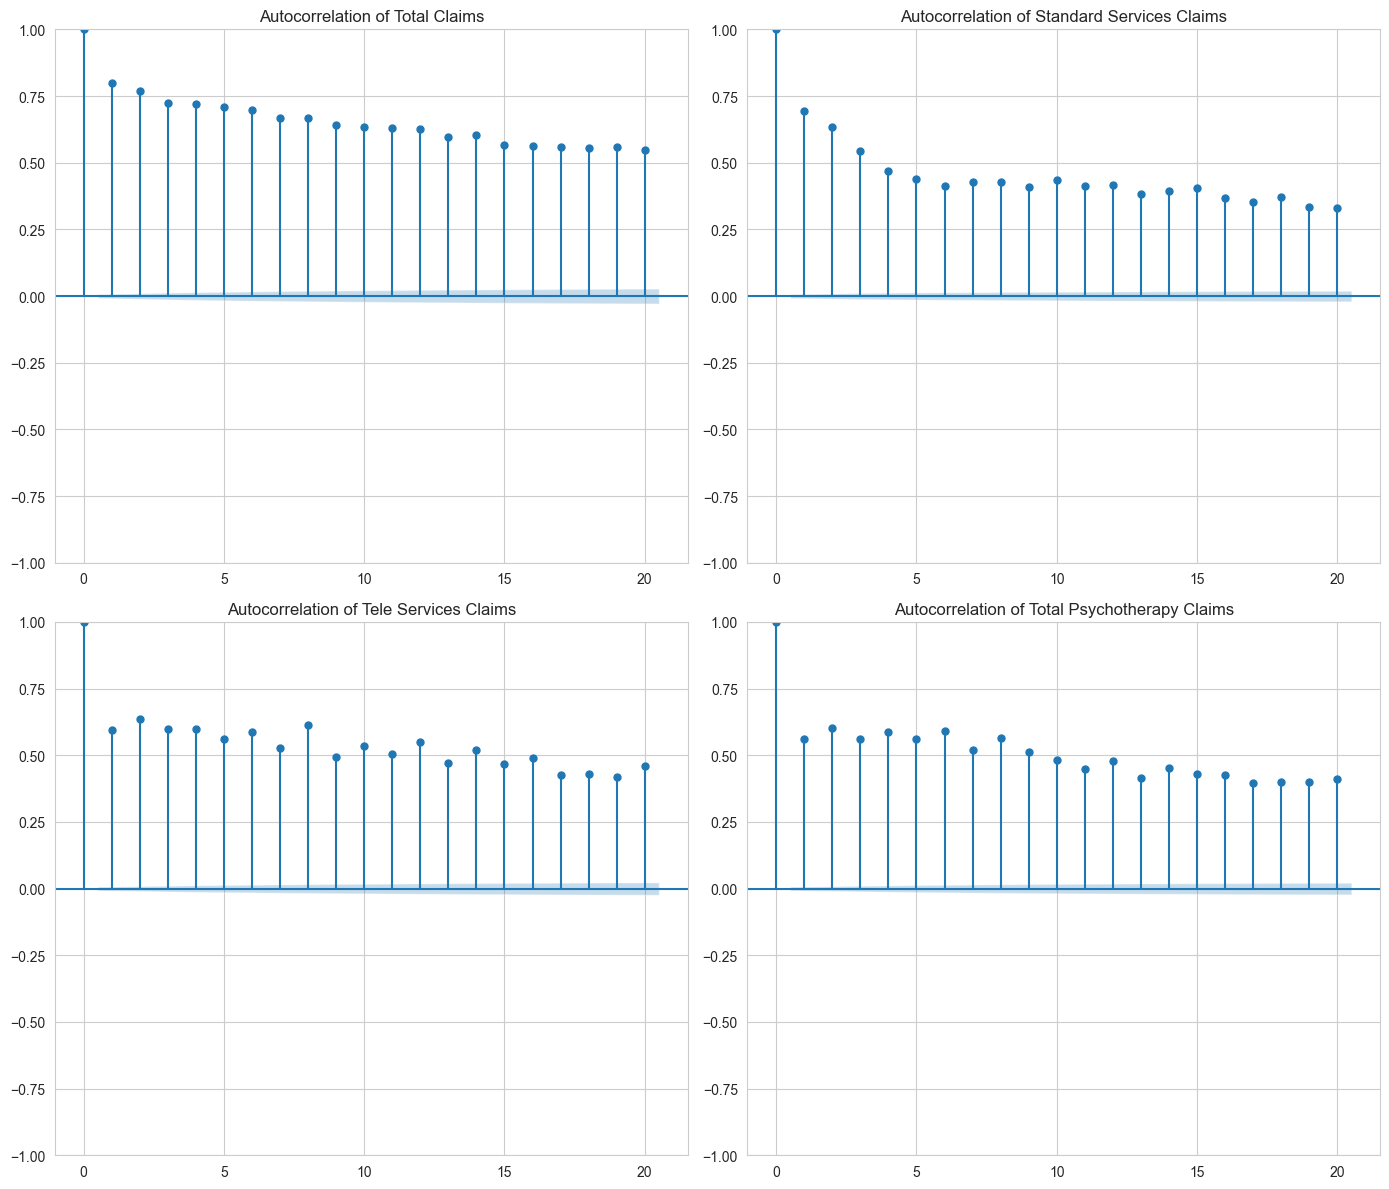

In [149]:
import statsmodels.api as sm

# Autocorrelation plot for total claims
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

sm.graphics.tsa.plot_acf(data['total_claims'].dropna(), lags=20, ax=ax[0, 0])
ax[0, 0].set_title('Autocorrelation of Total Claims')

# Autocorrelation plot for standard services claims
sm.graphics.tsa.plot_acf(data['standard_services_claims'].dropna(), lags=20, ax=ax[0, 1])
ax[0, 1].set_title('Autocorrelation of Standard Services Claims')

# Autocorrelation plot for tele services claims
sm.graphics.tsa.plot_acf(data['tele_services_claims'].dropna(), lags=20, ax=ax[1, 0])
ax[1, 0].set_title('Autocorrelation of Tele Services Claims')

# Autocorrelation plot for total psychotherapy claims
sm.graphics.tsa.plot_acf(data['total_psychotherapy_claims'].dropna(), lags=20, ax=ax[1, 1])
ax[1, 1].set_title('Autocorrelation of Total Psychotherapy Claims')

plt.tight_layout()
plt.show()

#### INSIGHT 12: Calculated Features Ratios

In [150]:
# Avoid division by zero by adding a small constant
epsilon = 1e-9

data['ratio_standard_services'] = data['standard_services_claims'] / (data['total_claims'] + epsilon)
data['ratio_tele_services'] = data['tele_services_claims'] / (data['total_claims'] + epsilon)
data['ratio_other_payers'] = data['total_other_payers_claims'] / (data['total_claims'] + epsilon)
data['ratio_commercial_claims'] = data['total_commercial_claims'] / (data['total_claims'] + epsilon)
data['ratio_medicaid_claims'] = data['total_medicaid_claims'] / (data['total_claims'] + epsilon)
data['ratio_medicare_claims'] = data['total_medicare_claims'] / (data['total_claims'] + epsilon)
data['ratio_psychotherapy_claims'] = data['total_psychotherapy_claims'] / (data['total_claims'] + epsilon)


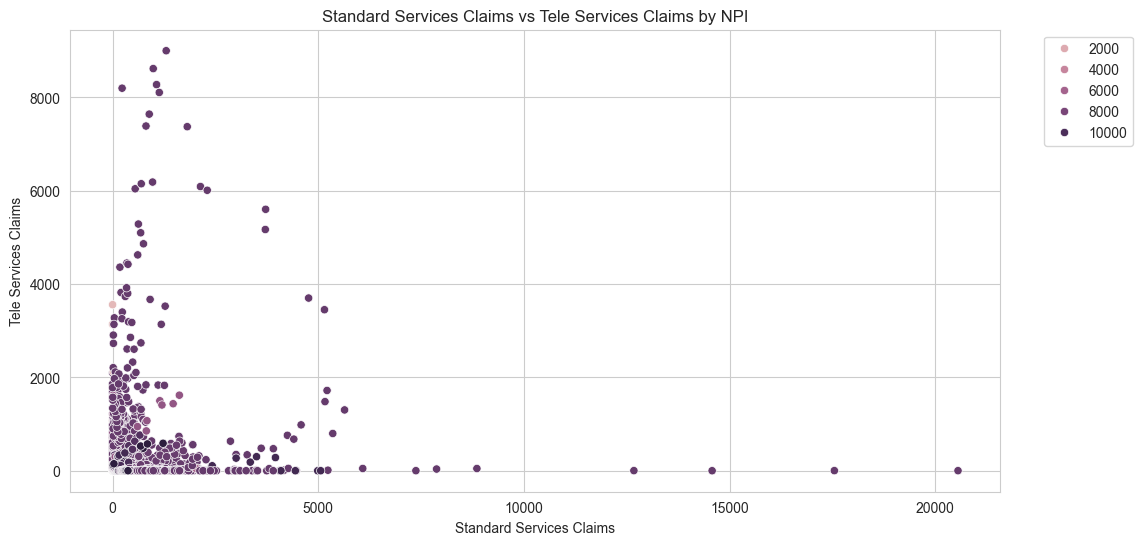

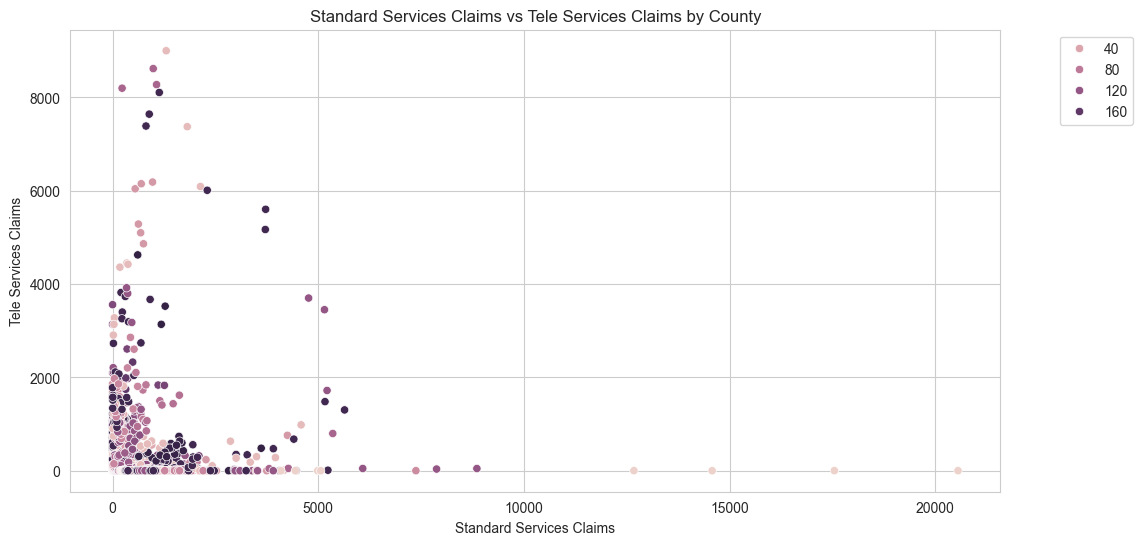

In [151]:
# Scatter plot by NPI
plt.figure(figsize=(12, 6))
sns.scatterplot(x='standard_services_claims', y='tele_services_claims', hue='npi', data=data)
plt.title('Standard Services Claims vs Tele Services Claims by NPI')
plt.xlabel('Standard Services Claims')
plt.ylabel('Tele Services Claims')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

# Scatter plot by County
plt.figure(figsize=(12, 6))
sns.scatterplot(x='standard_services_claims', y='tele_services_claims', hue='countyID', data=data)
plt.title('Standard Services Claims vs Tele Services Claims by County')
plt.xlabel('Standard Services Claims')
plt.ylabel('Tele Services Claims')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


### INSIGHT 13: 

In [152]:
# List of columns to be dropped
columns_to_drop = [
    "AH_Sign language services for the deaf and hard of hearing",
    "EN_English",
    "SP_Spanish",
    "NX_American Indian or Alaska Native languages",
    "FX_Other languages (excluding Spanish)",
    "F4_Arabic",
    "F17_Any Chinese Language",
    "F19_Creole",
    "F25_Farsi",
    "F28_French",
    "F30_German",
    "F31_Greek",
    "F35_Hebrew",
    "F36_Hindi",
    "F37_Hmong",
    "F42_Italian",
    "F43_Japanese",
    "F47_Korean",
    "F66_Polish",
    "F67_Portuguese",
    "F70_Russian",
    "F81_Tagalog",
    "F92_Vietnamese",
    "N24_Ojibwa",
    "N40_Yupik",
    "lat", "long"
]
data.drop(columns_to_drop, axis=1, inplace=True)

# Drop columns that start with '%'
columns_to_drop = [col for col in data.columns if col.startswith('%')]
data.drop(columns=columns_to_drop, inplace=True)

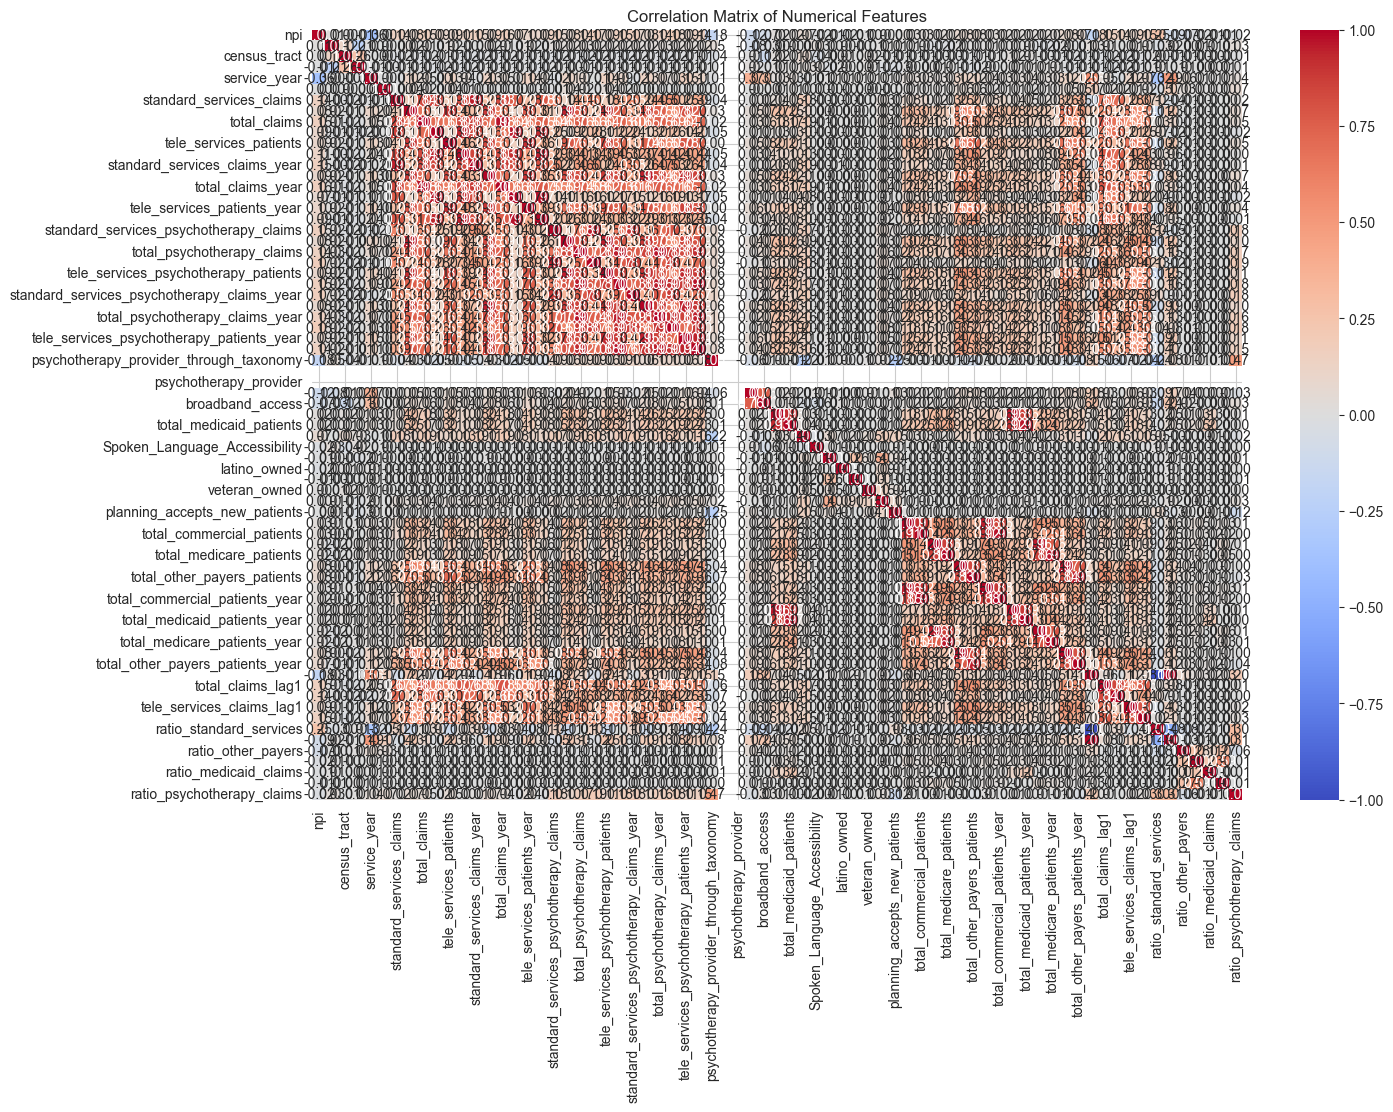

In [153]:
# Selecting numerical columns
numerical_features = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

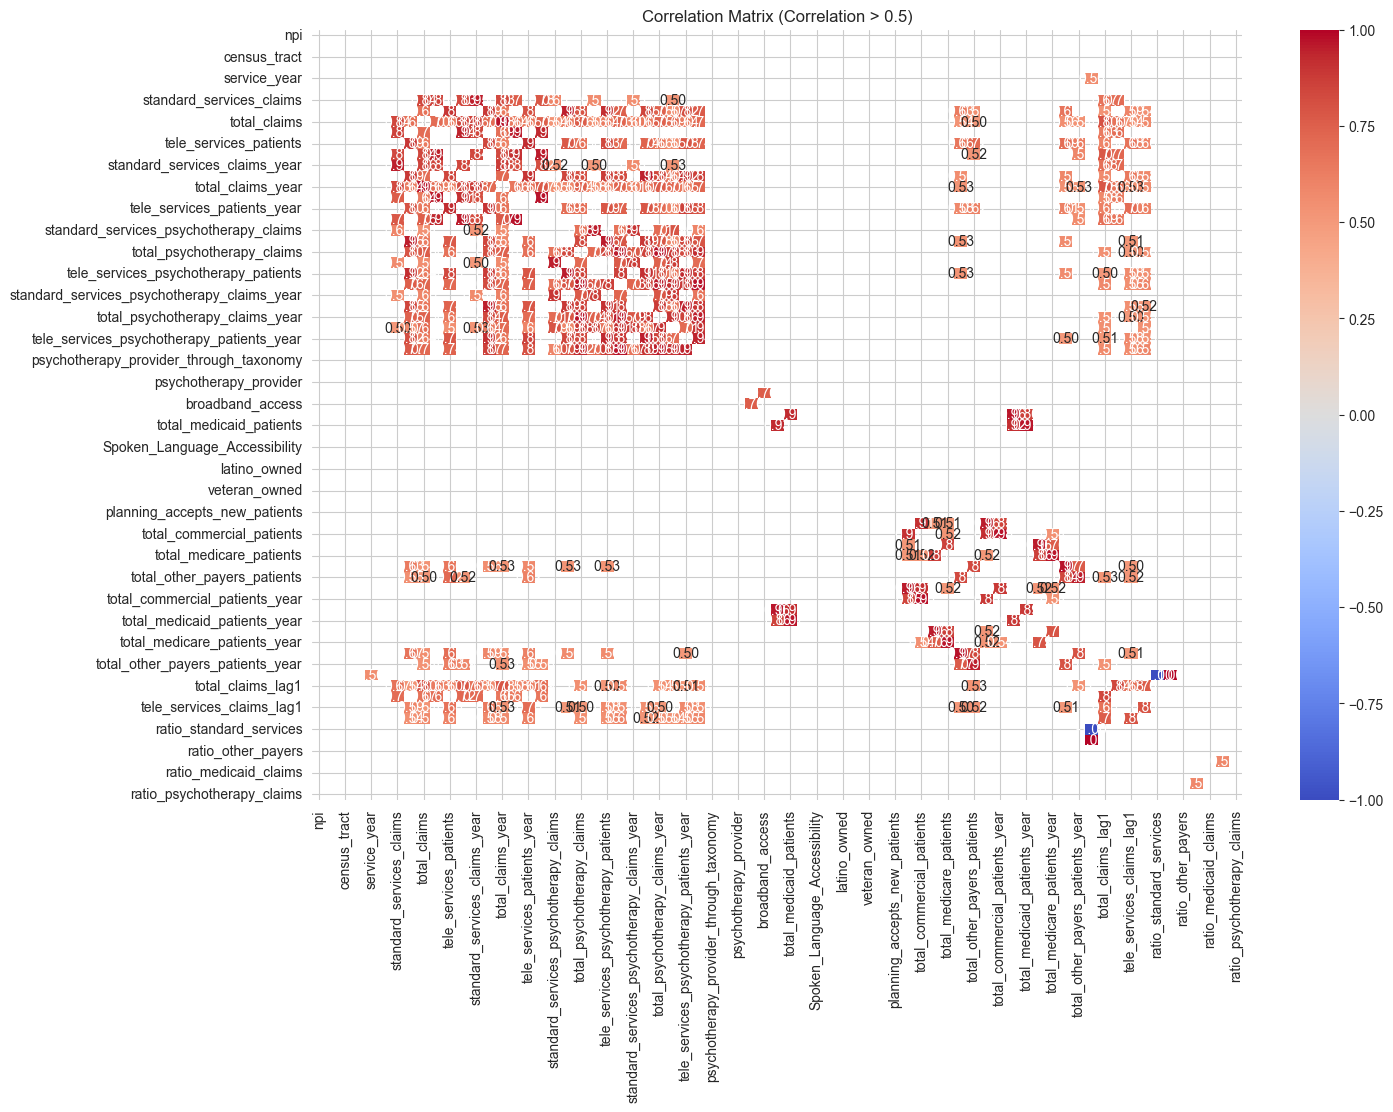

In [154]:
# Set the threshold for correlation
threshold = 0.5  # Adjust as needed

# Filter the correlation matrix to show only correlations above the threshold
high_corr_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)

# Plotting the filtered correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix[high_corr_pairs], annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Correlation > {})'.format(threshold))
plt.show()


In [155]:
# Selecting numerical columns
numerical_features = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Set the threshold for correlation
threshold = 0.5  # Adjust as needed

# Filter the correlation matrix to show only correlations above the threshold
high_corr_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)

# Extract the pairs of variables and their correlation coefficients
high_corr_variables = {}
for col in high_corr_pairs.columns:
    above_threshold = list(high_corr_pairs.index[high_corr_pairs[col]])
    for var in above_threshold:
        if var != col:
            high_corr_variables[(col, var)] = correlation_matrix.loc[col, var]

# Convert the results into a DataFrame
df_high_corr = pd.DataFrame(list(high_corr_variables.items()), columns=['Variable Pair', 'Correlation Coefficient'])

# Display the DataFrame
print("Variables with correlations above threshold ({}):".format(threshold))
df_high_corr.sort_values(by='Correlation Coefficient', ascending=True).head(10)


Variables with correlations above threshold (0.5):


,Variable Pair,Correlation Coefficient
582,"(ratio_standard_services, tele_claims_ratio)",-1.000000
512,"(tele_claims_ratio, ratio_standard_services)",-1.000000
351,"(total_psychotherapy_claims_year, tele_service...",0.500986
558,"(tele_services_claims_lag1, total_psychotherap...",0.500986
258,"(standard_services_psychotherapy_patients, sta...",0.501001
114,"(standard_services_claims_year, standard_servi...",0.501001
496,"(total_other_payers_claims_year, tele_services...",0.502054
388,"(tele_services_psychotherapy_patients_year, to...",0.502054
451,"(total_other_payers_claims, tele_services_clai...",0.503077
561,"(tele_services_claims_lag1, total_other_payers...",0.503077
